In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)

from scipy.stats import chi2_contingency
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, PowerTransformer
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
# Load data

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (59611, 24)
Test shape: (14900, 23)


In [3]:
# Basic config & column lists

id_col = 'founder_id'
target = 'retention_status'

log_cols = ['monthly_revenue_generated', 'funding_rounds_led', 'num_dependents', 'years_with_startup']

ordinal_cols_map = {
    'work_life_balance_rating': ['Poor', 'Fair', 'Good', 'Excellent'],
    'venture_satisfaction': ['Low', 'Medium', 'High', 'Very High'],
    'startup_performance_rating': ['Low', 'Below Average', 'Average', 'High'],
    'startup_reputation': ['Poor', 'Fair', 'Good', 'Excellent'],
    'founder_visibility': ['Low', 'Medium', 'High', 'Very High'],
    'startup_stage': ['Entry', 'Mid', 'Senior'],
    'team_size_category': ['Small', 'Medium', 'Large']
}
ordinal_feature_names = list(ordinal_cols_map.keys())
ordinal_categories = list(ordinal_cols_map.values())

nominal_cols = ['founder_gender', 'founder_role', 'education_background', 'personal_status']
binary_cols = ['working_overtime', 'remote_operations', 'leadership_scope', 'innovation_support']

initial_num_cols = [
    'monthly_revenue_generated', 'num_dependents', 'years_since_founding',
    'founder_age', 'years_with_startup', 'funding_rounds_led',
    'distance_from_investor_hub'
]

# Ensure only columns that exist in the dataset are used
numerical_cols = [c for c in initial_num_cols if c in train.columns]
binary_cols = [c for c in binary_cols if c in train.columns]
ordinal_feature_names = [c for c in ordinal_feature_names if c in train.columns]
ordinal_categories = [ordinal_cols_map[c] for c in ordinal_feature_names]
nominal_cols = [c for c in nominal_cols if c in train.columns]

all_cat_cols = binary_cols + ordinal_feature_names + nominal_cols


In [4]:
# Encode target early for EDA

if target in train.columns:
    train[target] = train[target].map({'Stayed': 1, 'Left': 0}).astype(int)
else:
    raise KeyError(f"{target} not present in train")


In [5]:
# Drop duplicates if any

dup_count = train.duplicated().sum()
if dup_count > 0:
    train.drop_duplicates(inplace=True)
    train.reset_index(drop=True, inplace=True)
    print(f"Duplicates removed. New train shape: {train.shape}")


Duplicates removed. New train shape: (59598, 24)



--- Target Distribution ---


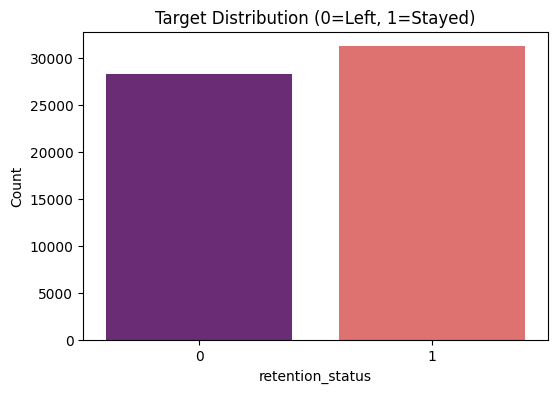

retention_status
1    0.524514
0    0.475486
Name: proportion, dtype: float64


In [6]:
# EDA: Target Distribution

print("\n--- Target Distribution ---")
plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=train, palette='magma')
plt.title('Target Distribution (0=Left, 1=Stayed)')
plt.ylabel('Count')
plt.show()
print(train[target].value_counts(normalize=True))


--- Missing Value Analysis ---
                           Missing Percentage
work_life_balance_rating             0.169989
venture_satisfaction                 0.119987
num_dependents                       0.079986
years_since_founding                 0.069986
team_size_category                   0.049985
monthly_revenue_generated            0.029984


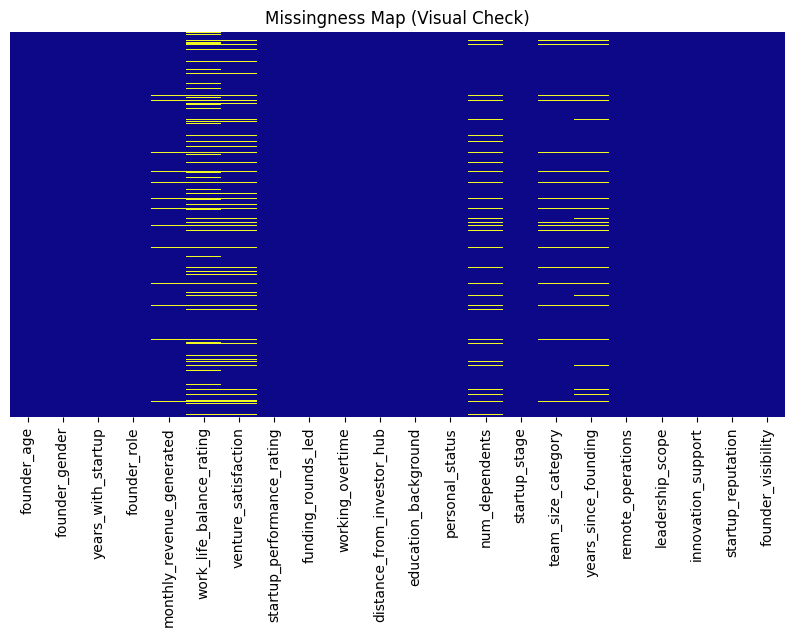

In [7]:
# EDA: Missing values

print("\n--- Missing Value Analysis ---")
missing_pct = train.isnull().mean().sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Percentage': missing_pct[missing_pct > 0]})
print(missing_df)

plt.figure(figsize=(10, 5))
cols_for_map = [c for c in train.columns if c not in [id_col, target]]
sns.heatmap(train[cols_for_map].isnull(), cbar=False, yticklabels=False, cmap='plasma')
plt.title('Missingness Map (Visual Check)')
plt.show()


--- Numerical Feature Distributions and Skew ---


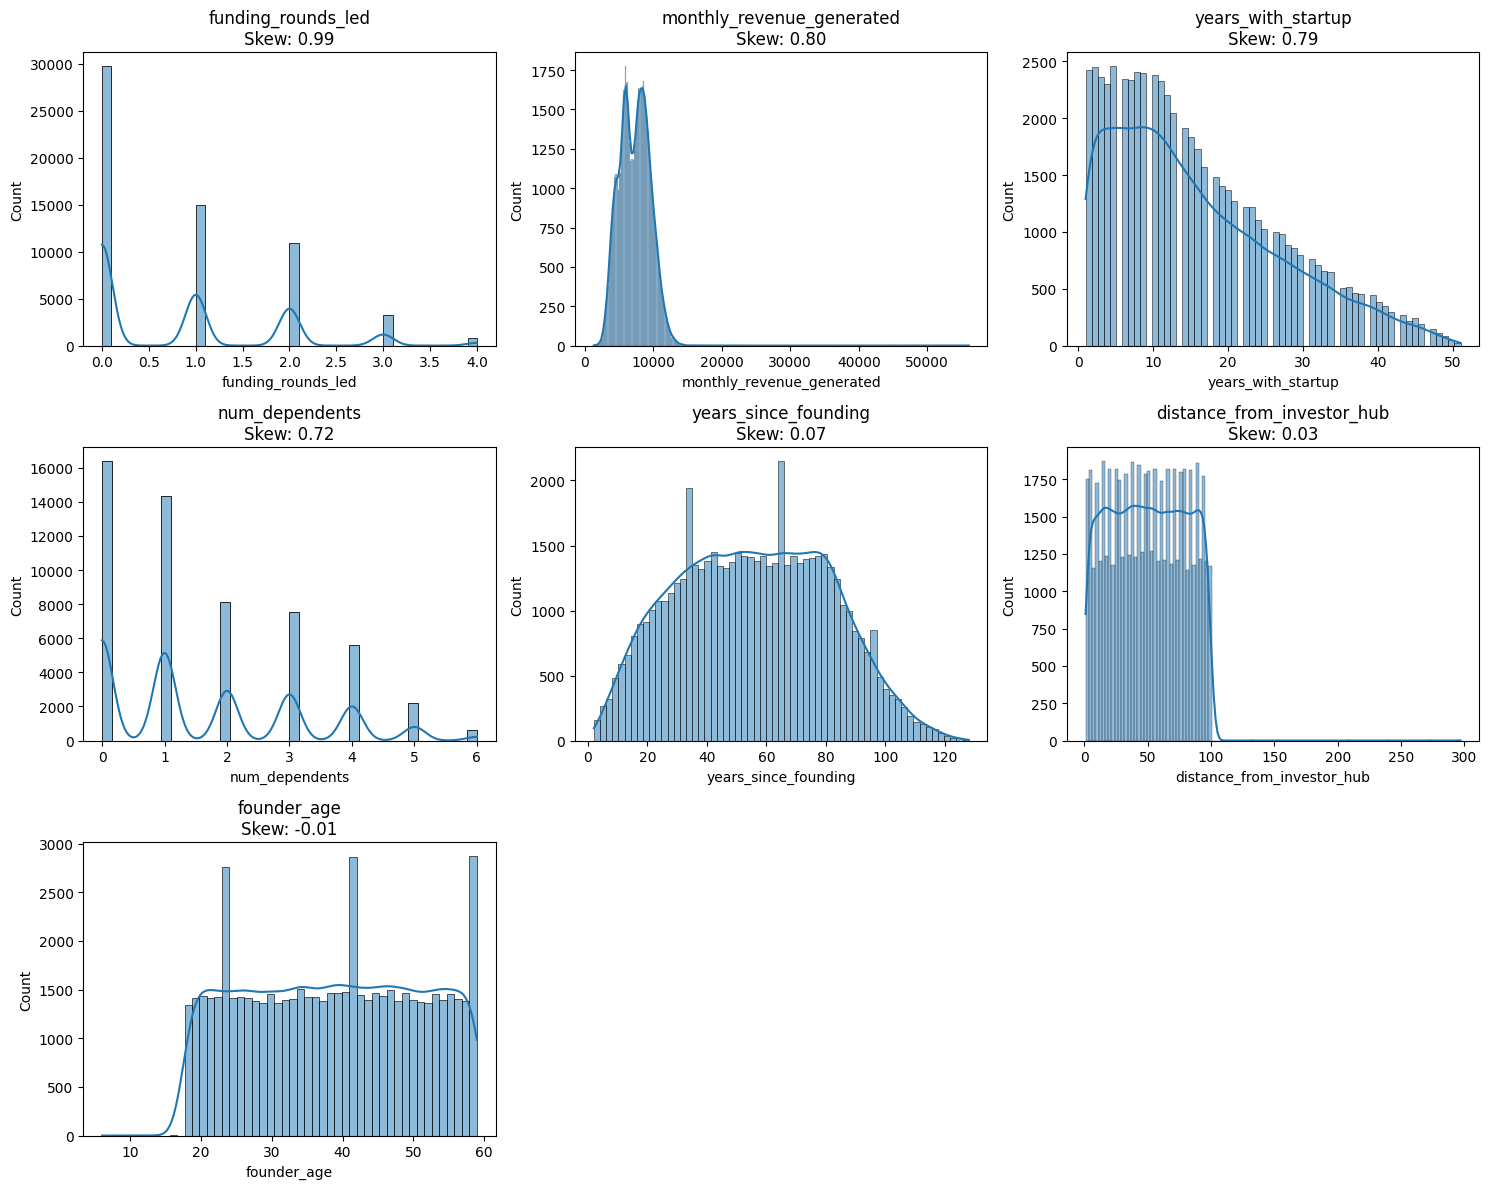

In [8]:
# EDA: Numerical distributions & skew

num_cols_for_eda = [c for c in numerical_cols if c in train.columns]
if num_cols_for_eda:
    print("\n--- Numerical Feature Distributions and Skew ---")
    skew_values = train[num_cols_for_eda].skew().sort_values(ascending=False)
    plt.figure(figsize=(15, 12))
    for i, col in enumerate(skew_values.index.tolist()[:8], 1):
        plt.subplot(3, 3, i)
        sns.histplot(train[col].dropna(), kde=True, bins='auto')
        plt.title(f'{col}\nSkew: {skew_values[col]:.2f}')
    plt.tight_layout()
    plt.show()


--- Numerical Feature Correlation ---


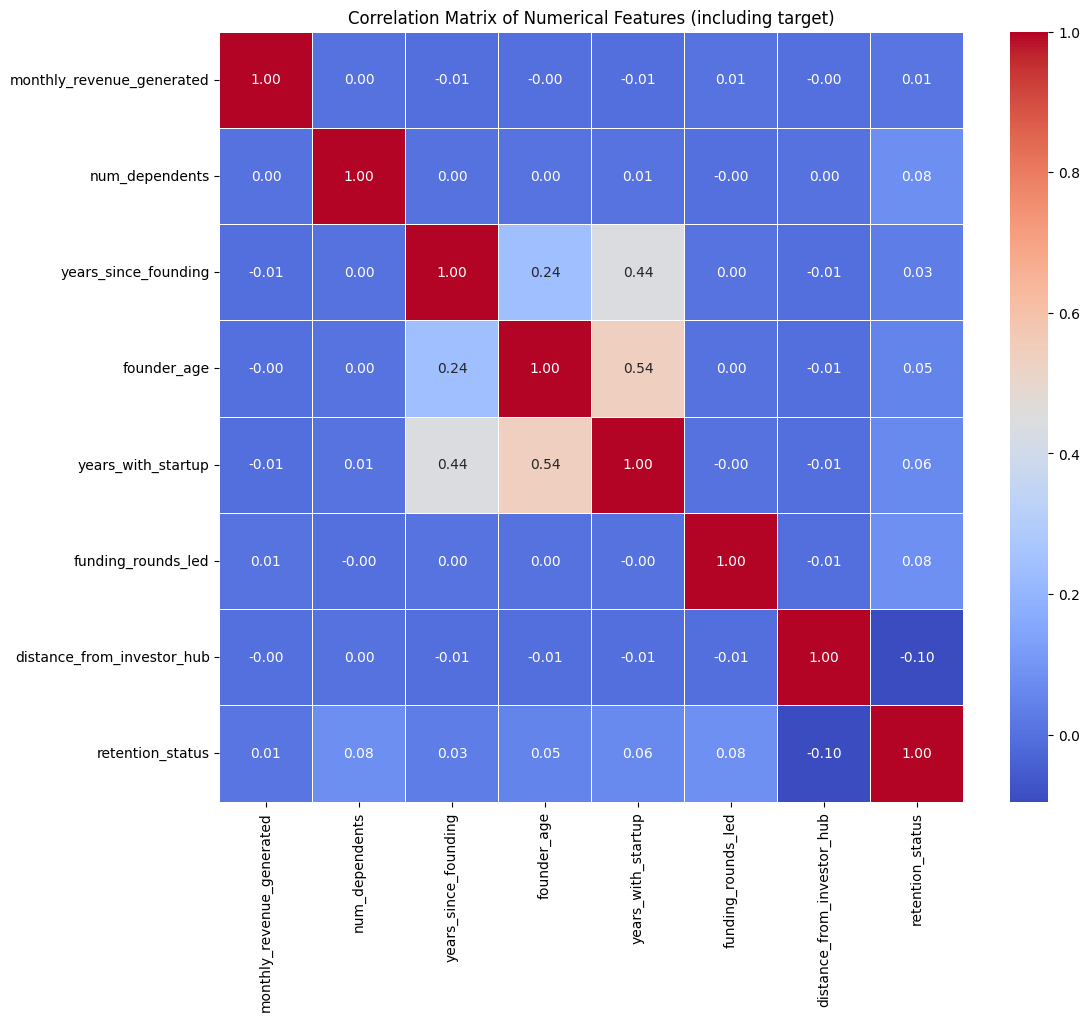

In [9]:
# EDA: Correlation matrix

num_corr_cols = [c for c in (num_cols_for_eda + [target]) if c in train.columns]
if len(num_corr_cols) >= 2:
    print("\n--- Numerical Feature Correlation ---")
    plt.figure(figsize=(12, 10))
    sns.heatmap(train[num_corr_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features (including target)')
    plt.show()

In [10]:
# EDA: Chi-square for categorical features

if all_cat_cols:
    print("\n--- Chi-Square Test for Categorical Significance ---")
    print(f"{'Feature':<35} | {'P-Value':<10} | {'Conclusion'}")
    print("-" * 70)
    for col in all_cat_cols:
        if col not in train.columns:
            continue
        contingency_table = pd.crosstab(train[col].astype(str).fillna('Missing'), train[target])
        try:
            if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1:
                chi2, p, _, _ = chi2_contingency(contingency_table)
                conclusion = "Significant (KEEP)" if p < 0.05 else "Not Significant"
                print(f"{col:<35} | {p:.5f}   | {conclusion}")
            else:
                print(f"{col:<35} | N/A        | Skipped (insufficient variation)")
        except Exception as e:
            print(f"{col:<35} | N/A        | Error: {e}")


--- Chi-Square Test for Categorical Significance ---
Feature                             | P-Value    | Conclusion
----------------------------------------------------------------------
working_overtime                    | 0.00000   | Significant (KEEP)
remote_operations                   | 0.00000   | Significant (KEEP)
leadership_scope                    | 0.01353   | Significant (KEEP)
innovation_support                  | 0.00000   | Significant (KEEP)
work_life_balance_rating            | 0.00000   | Significant (KEEP)
venture_satisfaction                | 0.00000   | Significant (KEEP)
startup_performance_rating          | 0.00000   | Significant (KEEP)
startup_reputation                  | 0.00000   | Significant (KEEP)
founder_visibility                  | 0.25073   | Not Significant
startup_stage                       | 0.00000   | Significant (KEEP)
team_size_category                  | 0.00000   | Significant (KEEP)
founder_gender                      | 0.00000   | Signifi

In [11]:
# 3. Feature Engineering (applied to copies of data)

def feature_engineer(df):
    df = df.copy()
    # revenue_per_year before log conversion (works with monthly revenue)
    if 'monthly_revenue_generated' in df:
        df['revenue_per_year'] = df['monthly_revenue_generated'] * 12

    # engineered features based on years & ages
    if 'years_with_startup' in df and 'years_since_founding' in df:
        df['experience_ratio'] = df['years_with_startup'] / (df['years_since_founding'] + 1e-9)
    if 'founder_age' in df and 'years_with_startup' in df:
        df['founder_join_age'] = df['founder_age'] - df['years_with_startup']

    # revenue per funding round (guard divide-by-zero)
    if 'monthly_revenue_generated' in df and 'funding_rounds_led' in df:
        # use monthly revenue; if funding rounds 0, denominator 1 to avoid inf
        df['revenue_per_round'] = df['monthly_revenue_generated'] / (df['funding_rounds_led'] + 1)

    # Log transform (create log_ prefixed features and remove originals if present)
    for c in log_cols:
        if c in df:
            df[f'log_{c}'] = np.log1p(df[c].fillna(0))
            try:
                df.drop(c, axis=1, inplace=True)
            except Exception:
                pass

    # Also create log of revenue_per_year if exists
    if 'revenue_per_year' in df:
        df['log_revenue_per_year'] = np.log1p(df['revenue_per_year'].fillna(0))
        try:
            df.drop('revenue_per_year', axis=1, inplace=True)
        except Exception:
            pass

    return df

# Apply to both train and test (feature engineering based on original values)
train_fe = feature_engineer(train)
test_fe = feature_engineer(test)

# Ensure id_col exists in test_fe for submission later
if id_col not in test_fe.columns and id_col in test.columns:
    test_fe[id_col] = test[id_col]

# Update numerical lists to include engineered features that exist
engineered_num_cols = [c for c in ['experience_ratio', 'founder_join_age', 'revenue_per_round', 'log_revenue_per_year'] if c in train_fe.columns]
numerical_cols = [c for c in initial_num_cols if c in train_fe.columns] + engineered_num_cols + [c for c in train_fe.columns if c.startswith('log_') and c not in initial_num_cols]

print("\nTotal numerical features considered:", len(numerical_cols))
print("Numerical features sample:", numerical_cols[:15])


Total numerical features considered: 12
Numerical features sample: ['years_since_founding', 'founder_age', 'distance_from_investor_hub', 'experience_ratio', 'founder_join_age', 'revenue_per_round', 'log_revenue_per_year', 'log_monthly_revenue_generated', 'log_funding_rounds_led', 'log_num_dependents', 'log_years_with_startup', 'log_revenue_per_year']


In [12]:
# 4. Outlier handling (capping) - applied after feature engineering

print("\n--- Outlier capping for selected numeric columns ---")
for col in ['founder_age', 'years_with_startup', 'years_since_founding']:
    if col in train_fe.columns:
        upper_bound = train_fe[col].quantile(0.99)
        train_fe[col] = train_fe[col].clip(upper=upper_bound)
        if col in test_fe.columns:
            test_fe[col] = test_fe[col].clip(upper=upper_bound)
        print(f"Capped {col} at {upper_bound:.2f}")



--- Outlier capping for selected numeric columns ---
Capped founder_age at 59.00
Capped years_since_founding at 110.00


In [13]:
# -----------------------------
# Prepare X, y and final test features
# -----------------------------
X_full = train_fe.drop(columns=[target, id_col], errors='ignore')
y_full = train_fe[target]
X_test_final = test_fe.drop(columns=[id_col], errors='ignore')

print("\nPrepared feature shapes (pre-split):", X_full.shape, X_test_final.shape)



Prepared feature shapes (pre-split): (59598, 26) (14900, 26)


In [14]:
# Create 20% mini-dataset then 80/20 train/val within it

# Step 1: take 20% of the full dataset as the mini-dataset
X_mini, _, y_mini, _ = train_test_split(
    X_full, y_full, test_size=0.80, random_state=42, stratify=y_full
)
print("\nMini-dataset shape (20% of full):", X_mini.shape)

# Step 2: split mini-dataset into 80% train and 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_mini, y_mini, test_size=0.20, random_state=42, stratify=y_mini
)
print("After internal split --> Train:", X_train.shape, "Val:", X_val.shape)



Mini-dataset shape (20% of full): (11919, 26)
After internal split --> Train: (9535, 26) Val: (2384, 26)


In [15]:
# Preprocessing pipelines definitions

# Build final numerical list for the preprocessor (only columns present)
num_for_preproc = [c for c in numerical_cols if c in X_train.columns]
bin_for_preproc = [c for c in binary_cols if c in X_train.columns]
ord_for_preproc = [c for c in ordinal_feature_names if c in X_train.columns]
nom_for_preproc = [c for c in nominal_cols if c in X_train.columns]

from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('power_transform', PowerTransformer(method='yeo-johnson')),  # reduce skew
    ('scaler', RobustScaler())
])

binary_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(categories=[['No','Yes']] * len(bin_for_preproc)))
])

ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[ordinal_categories[ordinal_feature_names.index(c)] for c in ord_for_preproc]))
])

nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

transformers = []
if num_for_preproc:
    transformers.append(('num', numerical_pipeline, num_for_preproc))
if bin_for_preproc:
    transformers.append(('bin', binary_pipeline, bin_for_preproc))
if ord_for_preproc:
    transformers.append(('ord', ordinal_pipeline, ord_for_preproc))
if nom_for_preproc:
    transformers.append(('nom', nominal_pipeline, nom_for_preproc))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop',
    verbose_feature_names_out=False
)
# Set output to DataFrame if available (scikit-learn >=1.2). If not available, we will wrap result into DataFrame later.
try:
    preprocessor.set_output(transform='pandas')
except Exception:
    pass

print("\nPreprocessor will handle:")
print("  Numerical:", num_for_preproc)
print("  Binary:", bin_for_preproc)
print("  Ordinal:", ord_for_preproc)
print("  Nominal:", nom_for_preproc)


Preprocessor will handle:
  Numerical: ['years_since_founding', 'founder_age', 'distance_from_investor_hub', 'experience_ratio', 'founder_join_age', 'revenue_per_round', 'log_revenue_per_year', 'log_monthly_revenue_generated', 'log_funding_rounds_led', 'log_num_dependents', 'log_years_with_startup', 'log_revenue_per_year']
  Binary: ['working_overtime', 'remote_operations', 'leadership_scope', 'innovation_support']
  Ordinal: ['work_life_balance_rating', 'venture_satisfaction', 'startup_performance_rating', 'startup_reputation', 'founder_visibility', 'startup_stage', 'team_size_category']
  Nominal: ['founder_gender', 'founder_role', 'education_background', 'personal_status']


In [16]:
# Quick sanity prints
print("\nSanity check value counts on target for mini-train/val:")
print("train target distr:", y_train.value_counts(normalize=True).to_dict())
print("val   target distr:", y_val.value_counts(normalize=True).to_dict())



Sanity check value counts on target for mini-train/val:
train target distr: {1: 0.524488725747247, 0: 0.475511274252753}
val   target distr: {1: 0.524748322147651, 0: 0.475251677852349}
